# Получение значений метрик

In [1]:
import sys
import json
import timeit
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from IPython import display

from modelgym.report import Report
from modelgym.utils import XYCDataset
from modelgym.trainers import TpeTrainer
from modelgym.metrics import Accuracy, RocAuc, F1

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

sys.path.append('../../gmm_modules/')
from data_preparation import get_train_test_data
from metrics import metric_boxplot, eval_metrics, dump_metrics
from modelgym_models import SVMClassifier

np.random.seed(10)
%matplotlib inline

/opt/conda/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.4 of module '_catboost' does not match runtime version 3.6
  return f(*args, **kwds)


## Подготовим данные

In [2]:
%%time
path_to_dataset = '../../../../SUSY.csv'
column_names = 'label, lepton 1 pT, lepton 1 eta, lepton 1 phi, lepton 2 pT, lepton 2 eta, lepton 2 phi, missing energy magnitude, missing energy phi, MET_rel, axial MET, M_R, M_TR_2, R, MT2, S_R, M_Delta_R, dPhi_r_b, cos(theta_r1)'.split(', ')
train_size = 400000
test_size = 100000

X_train, X_test, y_train, y_test = get_train_test_data(path_to_dataset, column_names, train_size, test_size)

CPU times: user 37.6 s, sys: 6.81 s, total: 44.4 s
Wall time: 1min 20s


In [3]:
# split X_train by class
X_good = X_train[np.where(y_train==0)[0]]
X_bad = X_train[np.where(y_train==1)[0]]  

In [4]:
X_good.shape, X_bad.shape, X_train.shape, X_test.shape

((200000, 18), (200000, 18), (400000, 18), (100000, 18))

## Подберем SVM с оптимальными параметрами

Создаем классификатор и trainer для подбора оптимальных параметров

In [5]:
models = [SVMClassifier]
trainer = TpeTrainer(models)

Обертка для данных

In [6]:
y_train_rescale = np.where(y_train == 0, np.ones((y_train.shape)), -np.ones((y_train.shape)))

In [ ]:
dataset = XYCDataset(X_train, y_train_rescale)

Сам подбор параметров

In [ ]:
%%time
trainer.crossval_optimize_params(RocAuc(), dataset, metrics=[Accuracy(), RocAuc(), F1()], verbose=True,
                                 cv=3, opt_evals=20)

*****************
{'kernel': {'coef0': 0.17782650433828304, 'degree': 6, 'gamma': 0.30345960645220954, 'kernel': 'poly'}, 'nu': 0.30000000000000004, 'shrinking': True}
{'kernel': 'poly', 'nu': 0.30000000000000004, 'shrinking': True, 'coef0': 0.17782650433828304, 'degree': 6, 'gamma': 0.30345960645220954}
Fitted
Run time: 891.61 sec
*****************

*****************
{'kernel': {'coef0': 0.17782650433828304, 'degree': 6, 'gamma': 0.30345960645220954, 'kernel': 'poly'}, 'nu': 0.30000000000000004, 'shrinking': True}
{'kernel': 'poly', 'nu': 0.30000000000000004, 'shrinking': True, 'coef0': 0.17782650433828304, 'degree': 6, 'gamma': 0.30345960645220954}
Fitted
Run time: 624.01 sec
*****************

*****************
{'kernel': {'coef0': 0.17782650433828304, 'degree': 6, 'gamma': 0.30345960645220954, 'kernel': 'poly'}, 'nu': 0.30000000000000004, 'shrinking': True}
{'kernel': 'poly', 'nu': 0.30000000000000004, 'shrinking': True, 'coef0': 0.17782650433828304, 'degree': 6, 'gamma': 0.3034596

Fitted
Run time: 456.98 sec
*****************

*****************
{'kernel': {'kernel': 'linear'}, 'nu': 0.2, 'shrinking': True}
{'kernel': 'linear', 'nu': 0.2, 'shrinking': True}
Fitted
Run time: 438.72 sec
*****************

*****************
{'kernel': {'gamma': 0.003212936366708991, 'kernel': 'rbf'}, 'nu': 0.6000000000000001, 'shrinking': False}
{'kernel': 'rbf', 'nu': 0.6000000000000001, 'shrinking': False, 'gamma': 0.003212936366708991}
Fitted
Run time: 1268.24 sec
*****************

*****************
{'kernel': {'gamma': 0.003212936366708991, 'kernel': 'rbf'}, 'nu': 0.6000000000000001, 'shrinking': False}
{'kernel': 'rbf', 'nu': 0.6000000000000001, 'shrinking': False, 'gamma': 0.003212936366708991}
Fitted
Run time: 1264.74 sec
*****************

*****************
{'kernel': {'gamma': 0.003212936366708991, 'kernel': 'rbf'}, 'nu': 0.6000000000000001, 'shrinking': False}
{'kernel': 'rbf', 'nu': 0.6000000000000001, 'shrinking': False, 'gamma': 0.003212936366708991}
Fitted
Run time: 1

Результаты

In [20]:
reporter = Report(trainer.get_best_results(), dataset, [Accuracy(), RocAuc(), F1()])

In [21]:
reporter.print_all_metric_results()


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    accuracy    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

                           tuned
SVMClassifier  0.697557 (+0.00%)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    roc_auc    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

                           tuned
SVMClassifier  0.843405 (+0.00%)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    f1_score    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

                           tuned
SVMClassifier  0.622969 (+0.00%)



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    accuracy    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



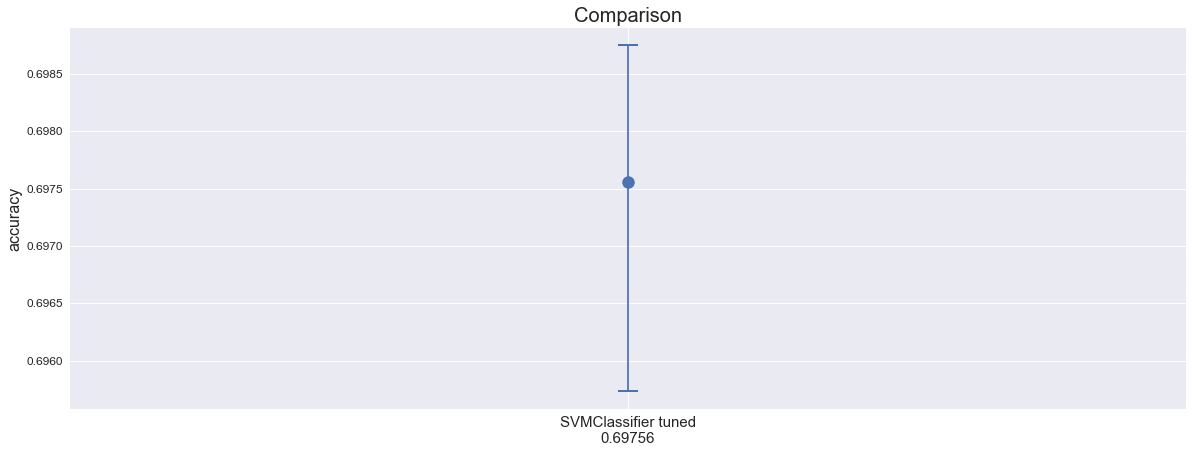


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    roc_auc    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



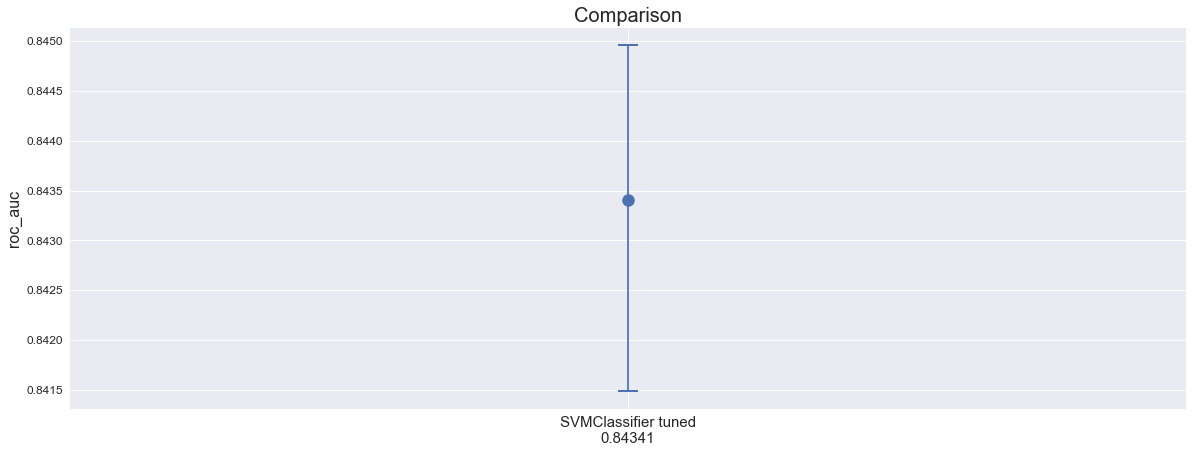


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    f1_score    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



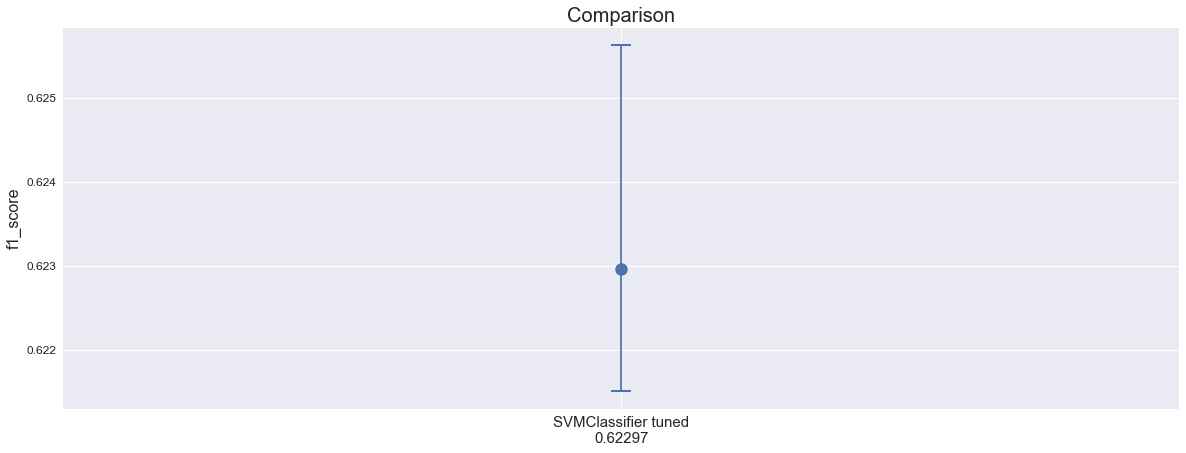

In [22]:
reporter.plot_all_metrics()

Вытащим значения оптимальных параметров

In [ ]:
trainer_log = trainer.state['SVMClassifier']
opt_params = trainer_log.best_trial['result']['params']
opt_params.update(opt_params['kernel'])
opt_params

Сохраним эти значения

In [25]:
file_name = 'optimal_svm_params.json'
with open(file_name, 'w', encoding="utf-8") as file:
    # writing
    json.dump(opt_params, file, indent=4, ensure_ascii=False)

Загрузим значения

In [5]:
file_name = 'optimal_svm_params.json'
with open(file_name, 'r', encoding="utf-8") as file:
    opt_params = json.load(file)

In [6]:
opt_params

{'coef0': 0.039551465111595074,
 'gamma': 0.004568048094611443,
 'kernel': 'sigmoid',
 'nu': 0.5000000000000001,
 'shrinking': True}

## Получим значения метрик OneClassSVM при оптимальных параметрах

In [7]:
y_test_rescale = np.where(y_test == 0, np.ones((y_test.shape)), -np.ones((y_test.shape)))

In [8]:
classifiers_classic_uns = {
    "One-Class SVM": OneClassSVM(**opt_params, verbose=True)
}

frac = 0
metrics_path = '../metrics/unsupervised/SVM_opt/'

metrics_dict = {
    'pr_aucs' : {},
    'roc_aucs' : {},
    'p_at_r' : {
        '0.8': {},
        '0.9': {}, 
        '0.95': {},
        '0.99': {},
    }
}

Run time: 9810.33 sec
PR_AUC:  (0, 0.8607933428607378)
ROC_AUC:  (0, 0.8426495752000001)
clf_name:  One-Class SVM


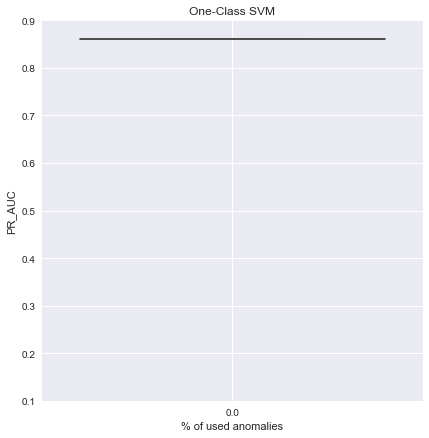

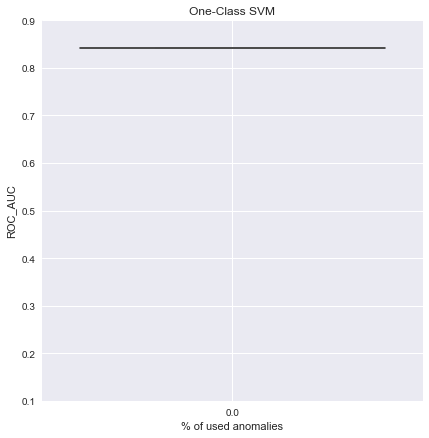

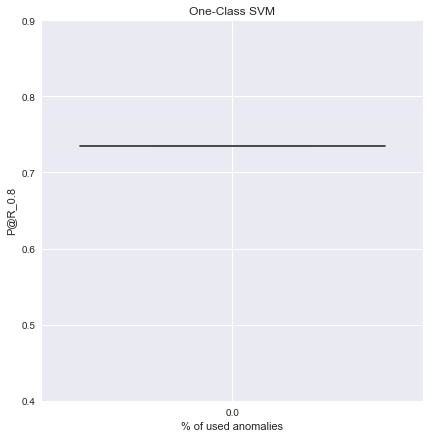

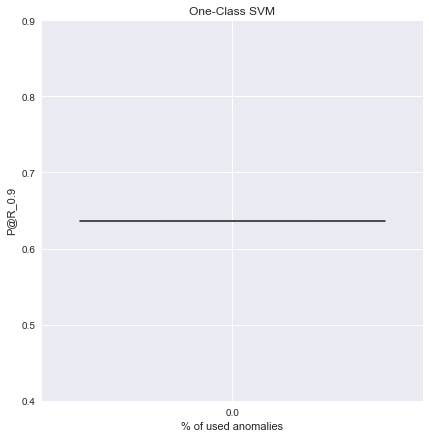

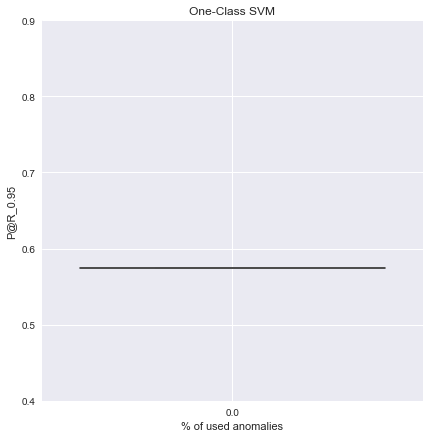

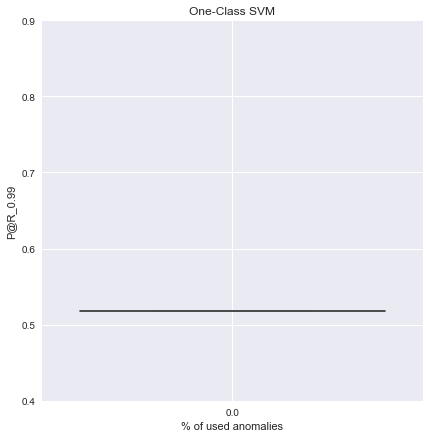

1it [2:43:32, 9812.66s/it]

CPU times: user 1h 48min 9s, sys: 6min 13s, total: 1h 54min 23s
Wall time: 2h 43min 32s


In [9]:
%%time
for i, (clf_name, clf) in tqdm(enumerate(classifiers_classic_uns.items())):
    # prepare data
    if frac > 1:
        end_ind = X_good.shape[0]
    else:   
        end_ind = int(X_good.shape[0] * frac)
    print('Ok1')

    idx_neg = np.random.permutation(X_bad.shape[0])
    X = np.concatenate((
        X_good,
        X_bad[idx_neg[:end_ind]]
    ), axis=0)
    print('Ok2')

    # fit model and predict probas
    start_time = timeit.default_timer()
    print('Ok3')
    clf.fit(np.random.permutation(X))
    print('Ok4')
    Score = clf.decision_function(X_test)
    run_time = timeit.default_timer() - start_time
    print('Ok5')
    
    # eval and save metrics
    eval_metrics(-y_test_rescale, -Score, frac, metrics_dict, descr=clf_name)
    dump_metrics(metrics_path, metrics_dict)

    # print info
    display.clear_output(wait=True)
    print("Run time: {:.2f} sec".format(run_time))
    print("PR_AUC: ", metrics_dict['pr_aucs'][clf_name][-1])
    print("ROC_AUC: ", metrics_dict['roc_aucs'][clf_name][-1])
    print('clf_name: ', clf_name)

    # plot metrics
    metric_boxplot(metrics_dict['pr_aucs'], ylabel='PR_AUC', ylim=(0.1, 0.9))
    plt.show()
    metric_boxplot(metrics_dict['roc_aucs'], ylabel='ROC_AUC', ylim=(0.1, 0.9))
    plt.show()
    for k in metrics_dict['p_at_r'].keys():
        metric_boxplot(metrics_dict['p_at_r'][k], ylabel='P@R_' + str(k), ylim=(0.4, 0.9))
        plt.show()

In [10]:
metrics_dict

{'p_at_r': {'0.8': {'One-Class SVM': [(0, 0.7353530525580455)]},
  '0.9': {'One-Class SVM': [(0, 0.6359486730165909)]},
  '0.95': {'One-Class SVM': [(0, 0.5741880114591014)]},
  '0.99': {'One-Class SVM': [(0, 0.51815060606695)]}},
 'pr_aucs': {'One-Class SVM': [(0, 0.8607933428607378)]},
 'roc_aucs': {'One-Class SVM': [(0, 0.8426495752000001)]}}